# AI534 IA2 - Logistic regression with L2 and L1 regularization

**Submission**:  
1. Your completed notebook in ipynb
2. a PDF report that includes all code outputs and figures. You can use the code block at the end of the notebook to generate a PDF export of the notebook with the outputs for your report. However, if any figures or outputs are missing, you must either:


* Manually add the missing figures to the PDF using a PDF editor or
* Copy your notebook contents into a Word or Google Doc, insert the missing outputs there, and export that document as a PDF.


**Overview.** In this assignment, we will implement and experiment with logistic regression with L2 and L1 regularization to predict whether a health insurance customer will purchase car insurance based on a set of features.

You may modify the starter code as you see fit, including changing the signatures of functions and adding/removing helper functions. However, please make sure that your TA can understand what you are doing and why.

First lets import the necessary packages.

In [1]:
# !pip install nbconvert > /dev/null 2>&1
# !pip install pdfkit > /dev/null 2>&1
# !apt-get install -y wkhtmltopdf > /dev/null 2>&1
# from google.colab import files

import os
import pdfkit
import contextlib
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# add more imports if necessary

# Part 0. (2 pts) Loading data and perform feature normalization for numerical features

---

On canvas, we have provided three different data files for this assignment: IA2-train.csv (for training), IA2-dev.csv(for validation) and IA2-train-noisy.csv (for Part 3). Download them and upload them to your google drive. Then mount the google drive from your google colab notebook:


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# train_path = '/content/gdrive/My Drive/AI534/IA2-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
# val_path = '/content/gdrive/My Drive/AI534/IA2-dev.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
# noisy_train_path = '/content/gdrive/My Drive/AI534/IA2-train-noisy.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path

#My local paths
train_path = './IA2-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = './IA2-dev.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
noisy_train_path = './IA2-train-noisy.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path

 ## 🚧 Preprocessing.
 You have one additional preprocessing step to do, which is to perform feature normalization (z-score) for 3 numerical features ("Age", "Annual_Premium", "Vintage").

In [3]:
# your code goes here
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
noisy_train_df = pd.read_csv(noisy_train_path)


def preprocess(train_df, df):

    train_df = train_df.copy()
    df = df.copy()

    #Normalize all columns except price
    for col_name in ["Age", "Annual_Premium", "Vintage"]:
        mu = train_df[col_name].mean()
        sigma =train_df[col_name].std()
        
        df[col_name] = (df[col_name] - mu) / sigma
    
    # Add bias column
    bias = pd.Series(0.0, index=df.index, name='bias')
    df = pd.concat([bias, df], axis=1)

    return df.drop(columns=['Response']), df['Response']

x_train, y_train = preprocess(train_df, train_df)
x_val, y_val = preprocess(train_df, val_df)
x_noisy_train, y_noisy_train = preprocess(noisy_train_df, noisy_train_df)

print("Train set (normalized features):")
print("Mean:", x_train.mean().round(2).to_list())
print("Std: ", x_train.std().round(2).to_list())

print("Val set (normalized features):")
print("Mean:", x_val.mean().round(2).to_list())
print("Std: ", x_val.std().round(2).to_list())

Train set (normalized features):
Mean: [0.0, 1.0, 0.59, -0.0, 1.0, 0.27, 0.71, -0.0, 0.0, 0.0, 0.0, 0.01, 0.02, 0.01, 0.0, 0.01, 0.01, 0.08, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.03, 0.0, 0.01, 0.02, 0.0, 0.0, 0.01, 0.0, 0.0, 0.01, 0.0, 0.0, 0.01, 0.34, 0.03, 0.03, 0.0, 0.01, 0.02, 0.0, 0.02, 0.02, 0.01, 0.01, 0.01, 0.0, 0.05, 0.0, 0.01, 0.0, 0.02, 0.05, 0.02, 0.01, 0.0, 0.02, 0.0, 0.0, 0.62, 0.31, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

# Part 1 (35 pts) Logstic regression with L2 (Ridge) regularization

For this part of the assignment, you will implement and experiment with Logistic regression with L2 regularization (Algorithm 1 in Assignment 2 Reference Information on canvas).


##  🚧  Impelement Logistic regression with L2 regularization
Your implemented function should take the following inputs:
1. The training data
2. The regularization parameter $\lambda$
3. The learning rate
4. Max iterations (recommend to start with 5000)
5. Threshold for change in loss (this will be used for early stopping: if the change in loss is less than the threshold, it is considered to have converged. Please use a threhold of $10^{-7}$. )

Your function should output the learned weight vector and the sequence of training losses, which will allow you to visualize the convergence process to ensure proper convergence. You should also implement a divergence detection, if the loss starts to diverge, terminate and raise an alarm.



In [ ]:
# your code goes here
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ridge_logistic_gradient_descent(x, y, gamma, lmbda, epochs, epsilon_loss=None, epsilon_grad=None):
    y=np.expand_dims(y, axis=-1)

    N,d = x.shape
    w = np.random.normal(0, 0.01, (d,1))
    losses = []

    for epoch in range(epochs):

        #Compute prediction
        y_pred = x @ w

        #Calculate loss
        sigma = sigmoid(y_pred)
        
        logistic_term = -np.mean(y * np.log(sigma) + (1 - y) * np.log(1 - sigma))
        reg_term = (lmbda/2) * np.sum(w[1:]**2) #Exclude bias from regularization

        ridge_loss = logistic_term + reg_term

        #Calculate gradient of the loss
        gradient_logistic = (1/N) * x.T @ (sigma-y)

        gradient_reg = lmbda * w
        gradient_reg[0] = 0 #Do not regularize bias

        gradient_ridge = gradient_logistic + gradient_reg

        #Perform gradient descent update
        w -= gamma * gradient_ridge 

        #Store loss
        losses.append(ridge_loss)

        if epsilon_loss is not None and epoch > 0:
            if abs(losses[-1] - losses[-2]) < epsilon_loss:
                print(f"Converged at epoch {epoch}")
                break
        
        if epsilon_grad is not None:
            if np.linalg.norm(gradient_ridge) < epsilon_grad:
                print(f"Gradient converged at epoch {epoch}")
                break
    
    return w, losses

# weights, losses = ridge_logistic_gradient_descent(x_train.to_numpy(), y_train.to_numpy(), gamma=0.01, lmbda=0.1, epochs=5000, epsilon_loss=10e-7)

# print(weights.shape)
# print(weights)

Converged at epoch 1617
(198, 1)
[[-1.14970022e-02]
 [-1.07076362e-01]
 [-1.33244229e-04]
 [ 2.66817147e-02]
 [-1.03466324e-01]
 [-6.12680280e-01]
 [ 5.52611870e-01]
 [ 4.77148381e-02]
 [-3.13053128e-02]
 [-3.56238593e-03]
 [-1.56887121e-03]
 [ 2.69673523e-03]
 [ 1.30034295e-02]
 [ 3.44104468e-04]
 [ 4.38929149e-03]
 [-5.76286249e-03]
 [-4.45484169e-03]
 [-2.94242853e-02]
 [-6.06783003e-03]
 [-6.11738814e-04]
 [-2.11158245e-03]
 [-1.01671390e-03]
 [ 1.59053576e-03]
 [ 2.47388044e-03]
 [-1.80984877e-02]
 [-8.96301938e-04]
 [-3.83350718e-03]
 [ 6.53428990e-04]
 [ 4.32951870e-03]
 [-2.98741458e-03]
 [-8.42396238e-03]
 [-1.49869728e-03]
 [ 3.76167949e-03]
 [ 8.89141961e-04]
 [-9.08985701e-03]
 [-2.93260994e-03]
 [-1.56202091e-03]
 [ 9.23431568e-02]
 [-6.30891509e-03]
 [-1.69617302e-02]
 [ 3.41190296e-03]
 [-2.40572345e-03]
 [-1.62380776e-02]
 [ 3.24939001e-03]
 [ 7.94036895e-03]
 [-1.21225560e-02]
 [-1.00246300e-02]
 [ 3.95830928e-03]
 [ 7.39144629e-03]
 [-1.71739268e-03]
 [-1.36528331e-04

## 🚧 Experiment with different regularization parameters
For this part, you will run your L2 logistic regression on the training data with different regularization strengths $\lambda\in \{10^i: i\in[-5, 0]\}$. This is the minimim range of values required for your exploration. You are encouraged to try additional intermediate or more extreme values if it helps you better analyze the results and answer the questions.

**Learning Rate Tuning Guidelines:**
The learning rate value ($\gamma$)  will need to be adjusted depending on the value of $\lambda$:
*   For very small $\lambda$ values (e.g.,$10^{-5}, 10^{-4}$), start with a  larger learning rate (e.g., $\gamma=1$) .
*   For moderate $\lambda$ values like $10^{-3}$, try a smaller learning rate like $\gamma = 0.1$.
*   As $\lambda$ increases further, continue decreasig the learning rate to maintain stable convergence.

** Why smaller learning rate for larger $\lambda$?**
Stronger regularization amplifies the contribution of the penalty term in the gradient. Using the same learning rate across all $\lambda$ values can lead to overly large update steps and unstable training. Adjusting the learning rate ensures smoother and more stable convergence.


**What to complete here.**
For each $\lambda$ value:

* Run your logistic regression until it converges(using your early stopping critierion).
* Record the final weight vector, which will be used later.
* Compute and record the training and validation accuracies
* Summarize your results in a clear table that lists each $\lambda$ value, the corresponding training accuracy, and validation accuracy. You will use this data in the next part to create your plots.

Learning rate: 0.001,   Regularization rate: 1
Converged at epoch 1850
0.49434482889335735
Learning rate: 0.01,   Regularization rate: 0.1
Converged at epoch 1623
0.7637095634068919
Learning rate: 0.1,   Regularization rate: 0.01
Converged at epoch 906
1.6149170325816
Learning rate: 1.0,   Regularization rate: 0.001
Converged at epoch 670
2.961652178437688
Learning rate: 1,   Regularization rate: 0.0001
Converged at epoch 1491
4.178954636289856


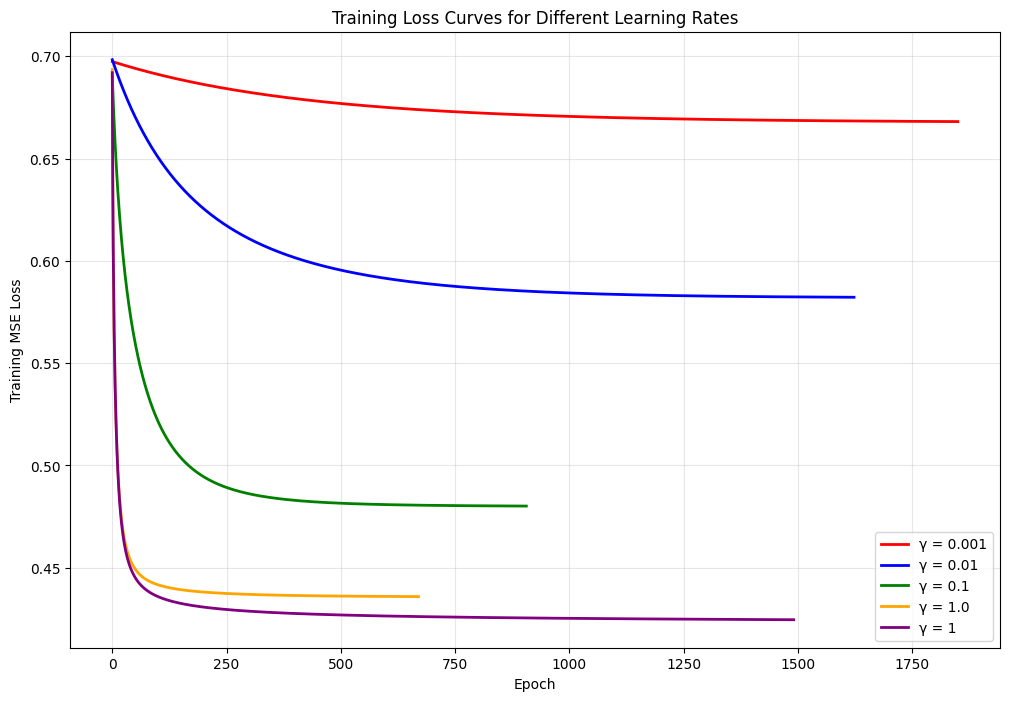

In [9]:
# Your code goes here
# Set random seed for reproducibility
np.random.seed(42)

reg_rates = [10**-i for i in range(0,5)]
learning_rates = [10e-4, 10e-3, 10e-2, 10e-1, 1, 1]

w_list = []
train_losses_list = []
converged_rates = []
val_mse_list = []

for i, (reg_rate, lr) in enumerate(zip(reg_rates, learning_rates)):
    print(f"Learning rate: {lr},   Regularization rate: {reg_rate}")
    
    w, losses = ridge_logistic_gradient_descent(x_train.to_numpy(), y_train.to_numpy(), gamma=lr, lmbda=reg_rate, epochs=5000, epsilon_loss=10e-7)
    
    # Check if converged (no NaN values)
    if not np.any(np.isnan(w)) and not np.any(np.isnan(losses)):
        w_list.append(w)
        train_losses_list.append(losses)
        converged_rates.append(lr)
        
        # Calculate validation MSE
        y_val_pred = x_val.to_numpy() @ w
        val_mse = np.mean((y_val_pred - y_val.to_numpy())**2)
        val_mse_list.append(val_mse)
        print(np.array(val_mse_list).mean())

plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, (lr, losses) in enumerate(zip(converged_rates, train_losses_list)):
    plt.plot(losses, color=colors[i % len(colors)], label=f'γ = {lr}', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Training MSE Loss')
plt.title('Training Loss Curves for Different Learning Rates')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 🚧 Visualize and analyze $\lambda$'s impact on training and validation accuracy

Now, use the results from your experiments to visualize how model performance changes with the regularization strength. Plot both the training accuracy and validation accuracy of your L2 regularized logistic regression model as a function of $\lambda$.
* Use a logarithmic scale for the x-axis to represent $\lambda$. Each tick mark on the x-axis should correspond to an integar $i$ and be labeled as $10^{i}$. This helps you clearly see performance trends across multiple orders of magnitude of $\lambda$.  

* Plot the two curves in the same figure, one for training accuracy and one for validation accuracy, using different colors for clarity.
* Include a legend to indicate which curve corresponds to which accuracy measure, and label the axis clearly.

Your final plot should make it easy to compare how regularization affects training vs. validation performance.

In [ ]:
# Your code goes here

## ✍️ Question

(a) Which $\lambda$ value leads to the best training and validation accuracy respectively? Which one should you use if you are to pick a model for deployment?

(b) What trend do you observe for the training and validation accuracy respectively as we increae $\lambda$? Provide your explanation for this observed trend.


**Your answer goes here**

## 🚧  Examine the impact on feature weights
For each value of $\lambda$, present the top five features based on the magnitude of their weights $|w_j|$, excluding the bias term $w_0$. Organize your results into a table. Each column should be dedicated to a specific $\lambda$ value, and rows should indicate the rank of the feature. Ensure that each cell in the table contains both the feature name and its corresponding weight $w_j$.

For example:

| Rank  | $\lambda = 10^{-4}$      | $\lambda = 10^{-3}$      | $\lambda = 10^{-2}$      |
|-------|--------------------------|--------------------------|--------------------------|
| 1     | feature_a, 0.8           | feature_b, 0.7           | feature_c, 0.6           |
| 2     | feature_d, 0.7           | feature_e, 0.6           | feature_f, 0.5           |
| 3     | feature_g, 0.6           | feature_h, 0.5           | feature_i, 0.4           |
| 4     | feature_j, 0.5           | feature_k, 0.4           | feature_l, 0.3           |
| 5     | feature_m, 0.4           | feature_n, 0.3           | feature_o, 0.2           |

The easiest way is to create a dataframe for this table and print the dataframe.

In [ ]:
#Your code goes here

## ✍️ Question

1. Do you observe any difference is the top features with different $\lambda$ values?
2. Do you observe any difference in the weights of the top features for different $\lambda$ values?
3. Please provide your own explanation/interpretation of the observed differences.

**Your answer goes here**

## 🚧 Examine the impact on sparsity of weights

For each different value of $\lambda$, compute the sparsity of the learned classifier as the number of feature weights that approxmately equal zero ($\leq 10^{-6}$) and report the sparsity number for each $\lambda$ value.

In [ ]:
# Your code goes here

## ✍️Question

1. When we have very small $\lambda$ values (aka very weak regularization), does your learned model have zero weights for some features?  If so, why would it be that way?
2. What trend do you observe for the sparsity of the model as we increase $\lambda$? If we further increase $\lambda$ to even larger values, what do you expect to happen to the sparsity value? Why?


**Your answer goes here**

# Part 2. (38 pts) Logistic regression with L1 regularization.

In this part, we will repeat the part 1 but with L1 regularization. Please refer to the algorithm 2 in the Assignment 2 Reference Information file for the details of the algorithm.

## 🚧 Impelement Logistic regression with L1 regularization
**Requirment.**
Implement Algorithm 2 (Proximal gradient descent for LASSO logistic regression) for L1 regularized Logistic Regress, described in the IA2 reference information sheet provided on Canvas. Your implemented function should take the following inputs:
1. The training data
2. The regularization parameter $\lambda$
3. The learning rate
4. Max iterations (recommend to start with 5000)
5. Threshold for change in loss (this will be used for early stopping: if the change in loss is less than the threshold, it is considered to have converged. Please use a threshold of $10^{-7}$. )

Your function should output the learned weight vector and the sequence of losses so that you can visualize the convergence process. You should also implement a divergence detection, if the loss starts to diverge, terminate and raise an alarm.


In [ ]:
# Your code goes here.

## 🚧 Experiment with different regularization parameters
For this part, you will need to apply your L1 logistic regression algorithm on the training data with different regularization parameters $\lambda\in \{10^i: i\in[-6, -1]\}$. You are encouraged to experiment with more extreme or in-between values if it helps you in answering the questions. But be advised using larger $\lambda$ values in this case makes it difficult to converge.

**Learning Rate Tuning Guidelines:**
For L1 regularization, I recommend starting with $\gamma = 2$ for very small $\lambda$s like $10^{-6}, 10^{-5}$, and decreasing the learning for larger $\lambda$ values.

**What to complete here.**
For each $\lambda$ value:
* Run your L1 regularized logistic regression until it converges(using your early stopping critierion).
* Record the final weight vector, which will be used later.
* Compute and record the training and validation accuracies
* Summarize your results in a clear table that lists each  λ  value, the corresponding training accuracy, and validation accuracy. You will use this data in the next part to create your plots.

In [ ]:
# Your code goes here

## 🚧 Visualize and analyze  λ 's impact on training and validation accuracy
Now, use the results from your experiments to visualize how model performance changes with the regularization strength. Plot both the training accuracy and validation accuracy of your L1 regularized logistic regression model as a function of $\lambda$.
* Use a logarithmic scale for the x-axis to represent $\lambda$. Each tick mark on the x-axis should correspond to an integar $i$ and be labeled as $10^{i}$. This helps you clearly see performance trends across multiple orders of magnitude of $\lambda$.  

* Plot the two curves in the same figure, one for training accuracy and one for validation accuracy, using different colors for clarity.
* Include a legend to indicate which curve corresponds to which accuracy measure, and label the axis clearly.

Your final plot should make it easy to compare how regularization affects training vs. validation performance.

In [ ]:
# Your code goes here

## ✍️Question
Based on your results, answer the following questions.

a. For L1 LR, which $\lambda$ value leads to the best training and validatoin accuracy respectively? If you were to select a model for deployment, which
$\lambda$ would you choose, and why?

b. What trend do you observe for the training and validation accuracy respectively as we increae $\lambda$? Explain this trend and provide an intuitive reasoning for why it occurs.

c. Comparing L1 and L2 regularized logistic regression, which one is more sensitive to the choice of the regularization parameter? An algorithm is considered sensitive if its performance or learned parameters change significantly when the regularization strength changes.
Since your experiments may have used a smaller range of $\lambda$ values for L1 regularization due to convergence concerns, you may use an off-the-shelf implementation (e.g., from scikit-learn) to explore this comparison more fully. Reflect on the differences you observe (or expect to observe) between L1 and L2 in terms of their sensitivity, and explain why.


**Your answer goes here**

## 🚧 Examine the impact on feature weights
For each value of $\lambda$, present the top five features based on the magnitude of their weights $|w_j|$, excluding the bias term $w_0$. Organize your results into a table. Each column should be dedicated to a specific $\lambda$ value, and rows should indicate the rank of the feature. Ensure that each cell in the table contains both the feature name and its corresponding weight $w_j$.

For example:

| Rank  | $\lambda = 10^{-4}$      | $\lambda = 10^{-3}$      | $\lambda = 10^{-2}$      |
|-------|--------------------------|--------------------------|--------------------------|
| 1     | feature_a, 0.8           | feature_b, 0.7           | feature_c, 0.6           |
| 2     | feature_d, 0.7           | feature_e, 0.6           | feature_f, 0.5           |
| 3     | feature_g, 0.6           | feature_h, 0.5           | feature_i, 0.4           |
| 4     | feature_j, 0.5           | feature_k, 0.4           | feature_l, 0.3           |
| 5     | feature_m, 0.4           | feature_n, 0.3           | feature_o, 0.2           |

In [ ]:
# Your code goes here

##✍️Question

1. Do you observe any difference is the top features with different $\lambda$ values?
2. Do you observe any difference in the weights of the top features for different $\lambda$ values?
3. Please provide your own explanation/interpretation of the observed differences.
4. What are some differences for this part of the results comparing L1 and L2 regularization? Provide your own explanation for such differences.


**Your answer goes here**

## 🚧 Examine the impact on sparsity of weights

For each different value of $\lambda$, compute the sparsity of the learned L1 regularized logistic regression classifier as the number of feature weights that approxmately equal zero ($\leq 10^{-6}$) and report the sparsity number for each $\lambda$ value.

In [ ]:
# Your code goes here

## ✍️Question

1. What trend do you observe for the sparsity of the L1 regularized model as we change $\lambda$? If we further increase $\lambda$, what do you expect? Why?
2. What are some differences for this part of the results comparing L1 and L2 regularization? Provide your own explanation for such differences.


**Your answer goes here**

# Part 3. (15 pts) Impact of Noise in Training Data
For this part, you will be training both L1 and L2 logistic regression models using the noisy training data (IA2-train-noisy.csv).

## 🚧 Experiment L1 and L2 Logistic Regression on Noisy Training data.
This experiment follows the same structure as Parts 1 and 2, so you can reuse your previous code—just provide the noisy training data (IA2-train-noisy.csv) as input.
You may also use an off-the-shelf implementation such as sklearn.linear_model.LogisticRegression, which will typically be more efficient than your custom version.
If you choose to use scikit-learn:
* Set the penalty argument to 'l1' or 'l2'.

* Use the 'liblinear' or 'saga' solver (required for L1).

* Remember that scikit-learn’s regularization parameter is defined as C=$\frac{1}{\lambda}$, so smaller 𝐶 values correspond to stronger regularization.

For each regularization type:

* Train the model for each λ value as specified in each part. (For L1, you can exclude $\lambda=0.1$, which can be difficult to converge)

* Record the accuracies on the noisy training data and the clean validation data for each $\lambda$ value.

* Plot both accuracies as functions of λ on a logarithmic x-axis, using distinct colors and a clear legend.

* Both curves (training and validation) should appear on the same figure for easy comparison.

Your plots should clearly illustrate how model performance changes with different regularization strengths under noisy conditions.

In [ ]:
# Your code goes here



## ✍️Question
Your experiments should reveal that when trained with the noisy data, both L1 and L2 regulated logistic regression have substantially reduced training accuracies, but only a small drop in validation accuracy.

Here I provide two possible explanations for this phenonmenon:
1. This is due to the use of regularization, which limits the model's ability to overfit to the noise.
2. This is due to the simplicity of the model, which prevents overfitting even without regularization.

Which explanation better accounts for your results, and why? Support your reasoning using evidence from your plots (e.g., how accuracy changes with
λ, or differences between L1 and L2).

Design a brief experiment to figure which explanation fits in this particular case. between these two explanations. Describe what you would vary, what you would keep fixed, and what outcome would support each hypothesis. (You only need to describe the experiment, not run it.)

**Your answer goes here.**

# Part 4. (10 pts) In-class competition
We will host a in-class competition using the IA2 data. To participate in this competition, use the following link:
https://www.kaggle.com/competitions/ai534-ia2-25

**Model restriction.** For this competition, you are required to use logistic regression models. You are welcome to use off-the-shelf implementations, such as sklearn.linear_model.LogisticRegression.

**Exploration encouraged.** To improve your model's performance, you may:

* Perform feature engineering (create, modify, or combine features).
* Manipulate the data (upsample or downsample the training set)
* Experiment with hyperparameter tuning.
* Try different regularization methods (e.g., L1, L2).


**Team work.** You should continue working in the same team for this competition. The training and validation data provided on the kaggle site are the same as the IA2 assignment.

**Evaluation** To participate, you will apply your trained/tuned model to the test data provided on kaggle (which does not contian the response column), and submit prediction files to be scored, based on prediction accuracy.

There are two parts to the score you will see on kaggle. The performance reported on the public leaderboard and a score reported on the private leaderboard. The public leader board scores are visible through out the competition and you can use it as an external validation to help you refine your model design and tune the model. The private leader board scores are evaluated using a separate set of test data as the final performance evaluation and will be released only after the competition is closed.

**Points and bonus points.** You will get the full 10 points if you

* participate in the competition (successful submissions)

* achieve non-trivial performance (outperform some simple baseline)

* complete the report on the competition below.

You will get 3 **nonus points** if your team scored top 3 on the private leader board, or entered the largest number of unique submissions (unique sores).

No late submission. The competition will be closed at 11:59 pm of the due date.

##✍️ Report on the Kaggle competition
1. Team name:
2. Exploration Summary: Brief describe the approches you tried.
3. Most Impactful Change: Which exploration led to the most performance improvement, and why do you think it helped?

In [ ]:
#running this code block will convert this notebook and its outputs into a pdf report.
!jupyter nbconvert --to html /content/gdrive/MyDrive/Colab\ Notebooks/IA2-2024.ipynb  # you might need to change this path to appropriate value to location your copy of the IA0 notebook

input_html = '/content/gdrive/MyDrive/Colab Notebooks/IA2-2024.html' #you might need to change this path accordingly
output_pdf = '/content/gdrive/MyDrive/Colab Notebooks/IA2output.pdf' #you might need to change this path or name accordingly

# Convert HTML to PDF
pdfkit.from_file(input_html, output_pdf)

# Download the generated PDF
files.download(output_pdf)